# _Faces of Fortune_

Determining the average face for the executive boards of each of the top 25 Fortune 500 companies.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2
from skimage import io
from collections import Counter
import os
import pickle
from google_images_download import google_images_download
from facer import facer
from io import BytesIO

Loading face detector and landmark prediction models...
Done, models loaded.


# Start the Selenium browser

The Fortune 500 page uses React, so BeautifulSoup HTML parsing won't cut it.

In [24]:
# Start a new instance of Chrome
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
browser = webdriver.Chrome('/usr/local/bin/chromedriver', chrome_options=chrome_options)
url = "https://fortune.com/fortune500/search/?"
browser.get(url)
time.sleep(5)

# Scroll down to list of endpoints (necessary?)
elem = browser.find_element_by_tag_name("body")
no_of_pagedowns = 8
while no_of_pagedowns:
    elem.send_keys(Keys.PAGE_DOWN)
    time.sleep(1)
    no_of_pagedowns-=1
    
time.sleep(5)
print("Done.")

/Users/john/.virtualenvs/average-faces/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.


Waiting for endpoints to load...


# Get the Fortune 500 page for each company 

In [141]:
# Extract the column names from the table
name = "searchResults__columnTitle--1Brf4"
header = browser.find_elements_by_class_name(name)
columns = [col.text for col in header]
columns.append("URL_FORBES")

In [142]:
# Get each row of the table
rows = browser.find_elements_by_class_name("rt-tr-group")

In [ ]:
# For each row in the table, extract the column values
link_name = "searchResults__cellWrapper--39MAj"
data = []
for n, row in enumerate(rows, 1):
    if n % 20 == 0 or n == 1:
        print(f"({n}/{len(rows)})")
    cells = row.find_elements_by_css_selector("div[role='gridcell']")
    values = [cell.text for cell in cells]
    
    # Get the Fortune URL for the company
    link = row.find_element_by_class_name(link_name).get_attribute("href")
    values.append(link)
    data.append({key:val for key, val in zip(columns, values)})

# Store the scraped data as a DataFrame
fortune = (pd.DataFrame(data)
        .set_index("RANK"))
fortune.to_csv("Fortune100.csv")
fortune.head()

# Load each company's web page

In [2]:
fortune = pd.read_csv("./Fortune100.csv").set_index("RANK")
fortune.head()

,NAME,REVENUES ($M),REVENUE PERCENT CHANGE,PROFITS ($M),PROFITS PERCENT CHANGE,ASSETS ($M),"MARKET VALUE — AS OF MARCH 29, 2019 ($M)",CHANGE IN RANK (FULL 1000),EMPLOYEES,CHANGE IN RANK (500 ONLY),URL_FORBES,URL_COMPANY,SEARCH_URL,URL_COMPANY_SUFFIX,URL_LEADERSHIP,URL_LEADERSHIP_ROOT,URL_DOMAIN
RANK,,,,,,,,,,,,,,,,,
1,Walmart,"$514,405.0",2.8%,"$6,670.0",-32.4%,"$219,295.0","$279,880.3",-,"2,200,000",-,https://fortune.com/fortune500/2019/walmart,http://www.walmart.com,https://www.google.com/search?q=Walmart+corpor...,walmart.com,https://corporate.walmart.com/our-story/leader...,https://corporate.walmart.com,.com
2,Exxon Mobil,"$290,212.0",18.8%,"$20,840.0",5.7%,"$346,196.0","$342,172.0",-,"71,000",-,https://fortune.com/fortune500/2019/exxon-mobil,http://www.exxonmobil.com,https://www.google.com/search?q=Exxon Mobil+co...,exxonmobil.com,https://corporate.exxonmobil.com/company/who-w...,https://corporate.exxonmobil.com,.com
3,Apple,"$265,595.0",15.9%,"$59,531.0",23.1%,"$365,725.0","$895,667.4",1,"132,000",1,https://fortune.com/fortune500/2019/apple,http://www.apple.com,https://www.google.com/search?q=Apple+corporat...,apple.com,https://www.apple.com/leadership/,https://www.apple.com,.com
4,Berkshire Hathaway,"$247,837.0",2.4%,"$4,021.0",-91.1%,"$707,794.0","$493,870.3",-1,"389,000",-1,https://fortune.com/fortune500/2019/berkshire-...,http://www.berkshirehathaway.com,https://www.google.com/search?q=Berkshire Hath...,berkshirehathaway.com,https://www.berkshirehathawayhs.com/pages/about,https://www.berkshirehathawayhs.com,.com
5,Amazon.com,"$232,887.0",30.9%,"$10,073.0",232.1%,"$162,648.0","$874,709.5",3,"647,500",3,https://fortune.com/fortune500/2019/amazon-com,http://www.amazon.com,https://www.google.com/search?q=Amazon.com+cor...,amazon.com,https://ir.aboutamazon.com/board-of-directors,https://ir.aboutamazon.com,.com


## Get the company website for each company

In [227]:
name = "dataTable__value--3n5tL dataTable__valueAlignLeft--3uvNx"
company_urls = []
for num_url, url_forbes in enumerate(fortune["URL_FORBES"]):
    if num_url % 20 == 0:
        print(url_forbes)
    page = requests.get(url_forbes)
    soup = BeautifulSoup(page.content, "lxml")

    items = list(map(lambda x: x.find("a"), soup.find_all(class_=name)))
    company_url = [item for item in items if item][0].get("href")
    company_urls.append(company_url)
    time.sleep(1)

# Update the DataFrame
fortune["URL_COMPANY"] = company_urls
fortune.to_csv("Fortune100.csv")

https://fortune.com/fortune500/2019/walmart
https://fortune.com/fortune500/2019/general-electric
https://fortune.com/fortune500/2019/ups
https://fortune.com/fortune500/2019/pfizer
https://fortune.com/fortune500/2019/oracle


In [367]:
fortune = pd.read_csv("./Fortune100.csv").set_index("RANK")

# Identify each company's leadership page

In [3]:
def get_google_search_url(company):
    return f"https://www.google.com/search?q={company}+corporate+leadership+page"

In [385]:
# Add the Google leadership search URLs to the DataFrame
fortune["SEARCH_URL"] = fortune["NAME"].apply(get_google_search_url)

# Strip the HTTPS stuff from the front of the company URL
fortune["URL_DOMAIN"] = fortune["URL_COMPANY"].apply(lambda x: "." + x.rsplit(".", 1)[-1])
fortune["URL_COMPANY_SUFFIX"] = fortune["URL_COMPANY"].apply(lambda x: ".".join(x.rsplit(".")[1:]))
fortune.to_csv("./Fortune100.csv")

In [ ]:
# Get each company's (likely) leadership page from Google searches
leadership_urls = []
cols = ["NAME", "URL_COMPANY_SUFFIX", "SEARCH_URL"]
for rank, (company, suffix, url) in fortune[cols].iterrows():
    if rank % 20 == 0 or rank == 1:
        print(f"({rank:2.0f}/{fortune.index.max()}): {company}")
        
    # Open the Google search page in Selenium
    browser.get(url)
    time.sleep(3)
    hits = browser.find_elements_by_class_name("bkWMgd")
    
    # Loop through the top hits on the page
    leadership_url = None
    for hit in hits:
        try:
            r = hit.find_element_by_class_name("r")
        except:
            continue
        hit_url = r.find_element_by_css_selector("a").get_attribute("href")
        if suffix in hit_url:
            leadership_url = hit_url
            break
    leadership_urls.append(leadership_url)
    
# Update the DataFrame
fortune["URL_LEADERSHIP"] = leadership_urls
fortune.to_csv("Fortune100.csv")

In [373]:
# Manually add the leadership URLs we missed
col = "URL_LEADERSHIP"
fortune.loc[4, col] = "https://www.berkshirehathawayhs.com/pages/about"
fortune.loc[9, col] = "https://investors.att.com/corporate-governance/leadership"
fortune.loc[12, col] = "https://media.ford.com/content/fordmedia/fna/us/en/people.filter.company-officers.0.50.html" # Might need manual work
fortune.loc[15, col] = "https://abc.xyz/investor/other/board/#" # Need to Google image search the names
fortune.loc[20, col] = "http://ir.kroger.com/management-and-directors" # Need to Google image search the names
fortune.loc[32, col] = "https://www.cmcsa.com/corporate-governance/executive-officers" # Requires manual work
fortune.to_csv("./Fortune100.csv")

In [387]:
# Determine the roots for each of the leadership URLs (for image paths later)
def get_leadership_url_root(row):
    try:
        return row["URL_LEADERSHIP"].rsplit(row["URL_DOMAIN"], 1)[0] + row["URL_DOMAIN"]
    except:
        return None

In [388]:
fortune["URL_LEADERSHIP_ROOT"] = fortune.apply(get_leadership_url_root, 1)
fortune.to_csv("./Fortune100.csv")

# Scrape all images from each company's leadership page

In [75]:
# https://stackoverflow.com/questions/52633697/selenium-python-how-to-capture-network-traffics-response
class ImageScraper(object):
    
    def __init__(self, wait_time=1):
        # Run this once to start the Chrome instance
        caps = DesiredCapabilities.CHROME
        caps['loggingPrefs'] = {'performance': 'ALL'}
        self.driver = webdriver.Chrome(desired_capabilities=caps)
        self.browser_log = None
        self.responses = None
        self.wait_time = wait_time # seconds
        
        # Maximize the window
        kwargs = dict(x=0, y=0, width=1340, height=900)
        self.driver.set_window_rect(**kwargs)
        
    def _load_page(self, url):
        # Load the page
        self.driver.delete_all_cookies()
        self.driver.get(url)
        self.driver.refresh()
        self.driver.delete_all_cookies()
        self.driver.get(url)
        time.sleep(0.2)
        
        # Scroll to the bottom & top of page, prompting image loads                
        elem = self.driver.find_element_by_tag_name("body")
        no_of_pagedowns = 10
        while no_of_pagedowns:
            elem.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.8)
            no_of_pagedowns-=1
        time.sleep(0.5)
        for pos in 2 * ["0", "document.body.scrollHeight"]:
            scroll = f"window.scrollTo(0, {pos});"
            self.driver.execute_script(scroll)
            time.sleep(0.2)
        time.sleep(0.5)
        self.browser_log = self.driver.get_log('performance')
        return

    def _process_browser_log_entry(self, entry):
        return json.loads(entry['message'])['message']

    def get_all_image_links(self, url):
        """Returns a list of all image URLs on the page"""
        self._load_page(url)
        
        # Parse the network events
        events = [self._process_browser_log_entry(entry) for entry in self.browser_log]
        events = [event for event in events if 'Network.response' in event['method']]
        events = pd.DataFrame([event['params'] for event in events])
        responses = pd.DataFrame(events[events.type == "Image"]['response'].tolist())
        self.responses = responses
        return responses['url'].drop_duplicates()
    
    def close(self):
        print("Closing browser... ", end="")
        self.driver.quit()
        print("Done.")        
    
    def __del__(self):
        self.close()

In [76]:
# Helper functions
def shape_or_ratio_is_good(imshape):
    return (imshape == most_common_shape) or (get_ratio(imshape) == most_common_ratio)

def okay_to_print(num, always_print=True):
    return num == 1 or num == N or num % 5 == 0 or always_print

def mimeType_is_valid(mimeType):
    return mimeType.rsplit("/", 1)[-1].lower() in ["png", "jpg", "jpeg", "webp"]

def download_image_links(links, company):
    images = {}
    sizes, skips = [], []
    for n, image_url in enumerate(links):
        alt = f"{company}_image_{n:02.0f}"
        try:
            image = io.imread(image_url)[..., ::-1]
        except:
            skips.append(image_url)
            continue

        # Keep the image URL, image array, and image size
        images[alt] = [image_url, image]
        sizes.append(image.shape)
    return images, sizes, skips

In [659]:
# Create the scraper instance, opening Chrome
scraper = ImageScraper()
scraper

In [ ]:
# Get the top 25 company's (likely) leadership page from Google searches
N = 100
cols = ["NAME", "URL_LEADERSHIP", "URL_LEADERSHIP_ROOT"]
all_image_links = {}
skipped_links = []
t0 = time.time()
for rank, (company, url, root) in fortune.head(N)[cols].iterrows():
    if rank <= 27:
        continue
    try:
        company = company.replace(" ", "_")
        if okay_to_print(rank):
            print(f"({rank:2.0f}/{N}): {company}\n\t{url}")
            
        # Get a link to every image on the pank
        image_links = scraper.get_all_image_links(url)
        valid_links = scraper.responses['mimeType'].apply(mimeType_is_valid)
        image_links = image_links[valid_links]
        all_image_links[company] = image_links

        # Attempt to read each image
        images, sizes, skips = download_image_links(image_links, company)
        skipped_links.extend(skips)
        if okay_to_print(rank):
            print(f"Downloaded {len(images)} images.")
        if len(images) == 0:
            continue

        # What's the most common image shape and ratio?
        get_ratio = lambda x: round(1000 * x[0] / x[1])
        most_common_shape = Counter([s[:2] for s in sizes]).most_common(1)[0][0]
        most_common_ratio = Counter(list(map(get_ratio, sizes))).most_common(1)[0][0]

        # Create a company images folder if it doesn't already exist
        folder = f"./images/{rank:02.0f}_{company}"
        if not os.path.exists(folder):
            os.mkdir(folder)

        # Save all images, but note the ones with questionable ratios
        for label, (image_url, array) in images.items():
            if not shape_or_ratio_is_good(array.shape[:2]):
                label += "_bad_size"
            label += ".jpg"
            fp = os.path.join(folder, label)
            cv2.imwrite(fp, array)

    except Exception as e:
        print(f"Error with '{company}':\n{e}")
    time.sleep(0.2)

# Close the browser
scraper.close()
del(scraper)

# Save the image links
with open(f"fortune_{N}_image_links.pickle", "wb") as outfile:
    pickle.dump(all_image_links, outfile)
print(f"All done. Total time elapsed: {(time.time() - t0) / 60:.2f} minutes.")

# Manual intervention

In [79]:
fortune = pd.read_csv("./Fortune100.csv").set_index("RANK")
bad_scrapes = [4, 6, 11, 14, 15, 20, 26, 28, 32, 35, 37]

# Rerun the Image Scraper

(when there are images on the page, but they weren't scraped well or something)

In [80]:
# Launch the browser
scraper = ImageScraper()

In [249]:
def read_image_from_link(url, invert=False):
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        print(r.status_code)
        return
    im = io.imread(BytesIO(r.content))
    return im[..., ::-1] if not invert else im

def download_and_save_images(company, rank, links, invert=False, swap_cols=False, start=0):
    folder = f"./images/{rank:02.0f}_{company.replace(' ', '_')}"
    for n, url in enumerate(links, start=start):
        print(f"({n + 1}/{len(links)}): '{url}'")
        # Save the image
        image = read_image_from_link(url, invert)
        if image is None:
            continue
        image = image[:, :, (2, 1, 0)] if swap_cols else image
        fp = f'{folder}/{company}_image_{n:02.0f}.jpg'
        cv2.imwrite(fp, image)
        time.sleep(1)

## (2) Exxon Mobil

Need more faces

In [556]:
url = "https://corporate.exxonmobil.com/company/who-we-are/corporate-governance/exxonmobil-board-of-directors#xxonobilorporationoardfirectors"

## (4) Berkshire Hathaway

In [457]:
links = scraper.get_all_image_links(url)
valid_links = scraper.responses['mimeType'].apply(mimeType_is_valid)

In [ ]:
company = "Berkshire_Hathaway"
download_and_save_images(company, 4, links[valid_links])

In [362]:
scraper = ImageScraper()

## (10) AmerisourceBergen

In [363]:
rank = 10
company = fortune.loc[rank, "NAME"]
url = "http://investor.amerisourcebergen.com/corporate-governance/management"
print(company)
print(url)

AmerisourceBergen
http://investor.amerisourcebergen.com/corporate-governance/management


In [364]:
links = scraper.get_all_image_links(url)
valid_links = scraper.responses['mimeType'].apply(mimeType_is_valid)
links = links[valid_links]

Closing browser... Done.


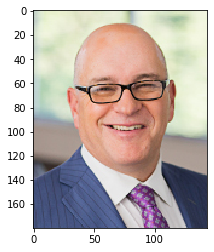

In [370]:
im = read_image_from_link(links.iloc[0], invert=True)
plt.imshow(im)

In [374]:
download_and_save_images(company, rank, links[:-1], invert=False, swap_cols=False)

(1/12): 'http://investor.amerisourcebergen.com/system/files-encrypted/styles/nir_person_large_bio_pic/encrypt/nasdaq_kms/people/migrations/Steve_Collis_140x190.jpg?itok=H4K0gIOJ'
(2/12): 'http://investor.amerisourcebergen.com/system/files-encrypted/styles/nir_person_large_bio_pic/encrypt/nasdaq_kms/people/migrations/James_Cleary_140x190.jpg?itok=mSLV8NcK'
(3/12): 'http://investor.amerisourcebergen.com/system/files-encrypted/styles/nir_person_large_bio_pic/encrypt/nasdaq_kms/people/2019/03/26/12-00-41/Silvana_Battaglia_140x180_rev.jpg?itok=8Ys_3O3m'
(4/12): 'http://investor.amerisourcebergen.com/system/files-encrypted/styles/nir_person_large_bio_pic/encrypt/nasdaq_kms/people/migrations/John_Chou_140x190.jpg?itok=5FUb1azR'
(5/12): 'http://investor.amerisourcebergen.com/sites/g/files/knoqqb4151/themes/site/nir_pid296/dist/images/Investors_Hero_Image.png'
(6/12): 'http://investor.amerisourcebergen.com/system/files-encrypted/styles/nir_person_large_bio_pic/encrypt/nasdaq_kms/people/migratio

## (11) Chevron

In [529]:
url = fortune.loc[[11]]["URL_LEADERSHIP"].iloc[0]
print(url)

https://www.chevron.com/about/leadership


In [530]:
links = scraper.get_all_image_links(url)
valid_links = scraper.responses['mimeType'].apply(mimeType_is_valid)
links = links[valid_links].apply(lambda x: x.rsplit("?", 1)[0])

In [ ]:
company = "Chevron"
folder = "./images/11_Chevron"
for n, url in enumerate(links):
    # Request the image
    print(f"{n}/{len(links)}: {url}")
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        print(r.status_code)
        break
        
    # Save the image
    image = r.raw.read()
    fp = f'{folder}/{company}_image_{n:02.0f}.jpg'
    open(fp, "wb").write(image)
    time.sleep(2)

## (26) Microsoft

In [148]:
rank = 26
url = fortune.loc[rank]["URL_LEADERSHIP"]
company = fortune.loc[rank]["NAME"]

In [82]:
links = scraper.get_all_image_links(url)
valid_links = scraper.responses['mimeType'].apply(mimeType_is_valid)
links = links[valid_links]

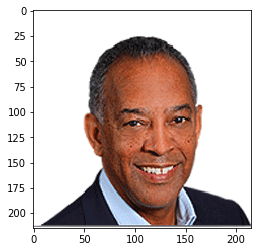

In [242]:
im = read_image_from_link(links.iloc[16], invert=True)
plt.imshow(im)

In [ ]:
download_and_save_images(company, rank, links.iloc[:16], invert=True)
download_and_save_images(company, rank, links.iloc[16:], invert=True, swap_cols=True, start=16)

## (35) DuPont

In [312]:
rank = 35
url = fortune.loc[rank]["URL_LEADERSHIP"]
company = fortune.loc[rank]["NAME"]
print(company)

DuPont de Nemours


In [314]:
scraper = ImageScraper()

In [315]:
links = scraper.get_all_image_links(url)
valid_links = scraper.responses['mimeType'].apply(mimeType_is_valid)
links = links[valid_links]

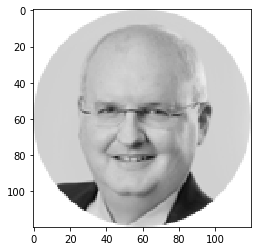

In [321]:
im = read_image_from_link(links.iloc[3], invert=True)
plt.imshow(im)

In [323]:
download_and_save_images(company, rank, links.iloc[2:], invert=True, swap_cols=True)

(1/20): 'https://www.dupont.com/content/dam/dupont/amer/us/en/corporate/about-us/leadership/desktop/corporate-circle-ed-breen-120x120.png'
(2/20): 'https://www.dupont.com/content/dam/dupont/amer/us/en/corporate/about-us/leadership/desktop/corporate-circle-marc-doyle-120x120.png'
(3/20): 'https://www.dupont.com/content/dam/dupont/amer/us/en/corporate/about-us/leadership/desktop/corporate-circle-jeanmarie-120x120.png'
(4/20): 'https://www.dupont.com/content/dam/dupont/amer/us/en/corporate/about-us/leadership/desktop/corporate-circle-erik-hoover-120x120.png'
(5/20): 'https://www.dupont.com/content/dam/dupont/amer/us/en/corporate/about-us/leadership/desktop/corporate-rose-lee-120x120-bw.png'
(6/20): 'https://www.dupont.com/content/dam/dupont/amer/us/en/corporate/about-us/leadership/desktop/corporate-circle-rs-120x120.png'
(7/20): 'https://www.dupont.com/content/dam/dupont/amer/us/en/corporate/about-us/leadership/desktop/corporate-mattias-heinzel-120x120-bw.png'
(8/20): 'https://www.dupont.

## (37) Johnson & Johnson

In [333]:
rank = 37
url = fortune.loc[rank, "URL_LEADERSHIP"]
company = fortune.loc[rank, "NAME"]
print(company)
print(url)

Johnson & Johnson
https://www.jnj.com/leadership/our-leadership-team


In [329]:
scraper = ImageScraper()

In [334]:
links = scraper.get_all_image_links(url)
valid_links = scraper.responses['mimeType'].apply(mimeType_is_valid)
links = links[valid_links]

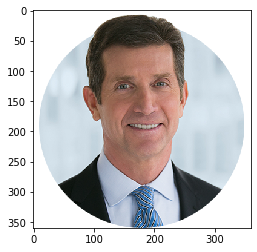

In [354]:
im = read_image_from_link(links.iloc[30], invert=True)
plt.imshow(im)

In [358]:
download_and_save_images(company, rank, links.iloc[30:], invert=True, swap_cols=True)

(1/22): 'https://jnj-content-lab.brightspotcdn.com/dims4/default/54101ff/2147483647/strip/true/crop/360x360+0+0/resize/360x360!/quality/90/?url=https%3A%2F%2Fjnj-content-lab.brightspotcdn.com%2F24%2F88%2Fb261d322488cbe8cfe5ee5bb9655%2Falex-gorsky-1.png'
(2/22): 'https://jnj-content-lab.brightspotcdn.com/dims4/default/63ffa64/2147483647/strip/true/crop/255x255+0+0/resize/360x360!/quality/90/?url=https%3A%2F%2Fjnj-content-lab.brightspotcdn.com%2F3d%2F96%2Fb9eb6b694b93a522270ccb1cca21%2Fround-joaquinduato-340.png'
(3/22): 'https://jnj-content-lab.brightspotcdn.com/dims4/default/2826760/2147483647/strip/true/crop/360x360+0+0/resize/360x360!/quality/90/?url=https%3A%2F%2Fjnj-content-lab.brightspotcdn.com%2F01%2Fcf%2Fc5b3877c4890842e70c75eed9f5e%2Fpeter-fasolo-1.png'
(4/22): 'https://jnj-content-lab.brightspotcdn.com/dims4/default/e7ac767/2147483647/strip/true/crop/360x360+0+0/resize/360x360!/quality/90/?url=https%3A%2F%2Fjnj-content-lab.brightspotcdn.com%2F83%2Fff%2F19167fb2480e831189e88f33

# Download images from names

(when there aren't any pictures on the company page)

In [31]:
response = google_images_download.googleimagesdownload()

In [279]:
def download_images_from_names(names, company, rank, extra_phrase=""):
    output_dir = f"./images/{rank:02.0f}_{company.replace(' ', '_')}"
    args = {"limit": 5, "silent_mode": True,
            "output_directory": output_dir, "no_directory": True, "delay": 0.1,
            "save_source": "face_image_urls", "print_urls": False,
            "no_download": True}

    for n, name in enumerate(names):
        print(f"({n + 1}/{len(names)}): {name}")
        query = f"{name} {company}{' ' + extra_phrase.lstrip(' ')}".strip()
        args["keywords"] = query
        image_path = response.download(args)
        key = list(image_path[0].keys())[0]

        # Check the image URLs for a face
        for url in image_path[0][key]:
            try:
                # Read the image URL
                r = requests.get(url)
                image = io.imread(BytesIO(r.content))[..., ::-1]
                found_faces = facer.detector(image, 1)
                if not found_faces or len(found_faces) != 1:
                    continue

                # Download the image if we found a face
                fp = os.path.join(output_dir, f"{n:02.0f}_{name.replace(' ', '_')}.jpg")
                cv2.imwrite(fp, image)
                break            
            except Exception as e:
                print(f"Error:\n\t{e}")
        time.sleep(1)
    print("All done.")

## (6) UnitedHealth Group

No images on page

In [40]:
rank = 6
company = fortune.loc[rank, "NAME"]
url = fortune.loc[rank, "URL_LEADERSHIP"]
print(company)
print(url)

UnitedHealth Group
https://www.unitedhealthgroup.com/about/executives.html


In [33]:
# Scrape the executives' names from the website
page = requests.get(url)
soup = BeautifulSoup(page.content, "lxml")

In [34]:
names = soup.find_all("h3")
names = [name.text.strip().split(",", 1)[0] for name in names]
print(names)

['Stephen J. Hemsley', 'David S. Wichmann', 'Larry C. Renfro', 'Cory B. Alexander', 'Ken Ehlert', 'Dirk McMahon', 'Richard Migliori', 'John Rex', 'Dan Schumacher', 'Marianne D. Short', 'D. Ellen Wilson', 'Andrew Witty', 'Terry M. Clark', 'Brett Manderfeld', 'Tom Roos', 'Jennifer Whitlow']


In [ ]:
download_images_from_names(names, company, rank)

## (14) Costco Wholesale

No images on page

In [41]:
rank = 14
company = fortune.loc[rank, "NAME"]
url = fortune.loc[rank, "URL_LEADERSHIP"]
print(company)
print(url)

Costco Wholesale
http://investor.costco.com/executive-officers


In [42]:
# Scrape the executives' names from the website
page = requests.get(url)
soup = BeautifulSoup(page.content, "lxml")

In [45]:
names = soup.find_all(class_="nir-widget--field nir-widget--person--name")
names = [name.text.strip().split(",", 1)[0] for name in names]
print(names)

['Jeff Abadir', 'Claudine Adamo', 'Andree T. Brien', 'Don Burdick', 'Pat Callans', 'Richard Chang', 'Richard C. Chavez', 'Victor A. Curtis', 'Richard Delie', 'Caton Frates', 'John B. Gaherty', 'Richard A. Galanti', 'Jaime Gonzalez', 'Bill Hanson', 'Dan Hines', 'W. Craig Jelinek', 'Jim Klauer', 'Paul W. Latham', 'Franz Lazarus', 'Jeffrey Long', 'Jeffrey Lyons', 'Russ Miller', 'Ali Moayeri', 'Paul G. Moulton', 'James P. Murphy', 'Bob Nelson', 'Mario Omoss', 'Stephen M. Pappas', 'Joseph P. Portera', 'Pierre Riel', 'Timothy L. Rose', 'Yoram Rubanenko', 'James W Rutherford', 'David Skinner', 'John Sullivan', 'John Thelan', 'Ron Vachris', 'Darby  Greek', 'Rich Wilcox']


In [46]:
download_images_from_names(names, company, rank)

(1/39): Jeff Abadir
Error:
	No connection adapters were found for 'x-raw-image:///0c5cd2028de28e88a6119873beb39cec77dcc3c623d0eda795f58d3699f3820d'
Error:
	Could not find a format to read the specified file in mode 'i'
(2/39): Claudine Adamo
(3/39): Andree T. Brien
(4/39): Don Burdick
(5/39): Pat Callans
(6/39): Richard Chang
(7/39): Richard C. Chavez
Error:
	Could not find a format to read the specified file in mode 'i'
Error:
	Could not find a format to read the specified file in mode 'i'
(8/39): Victor A. Curtis
(9/39): Richard Delie
Error:
	No connection adapters were found for 'x-raw-image:///0e3304fe72c65690d48b9ea7cc47021aa788d12b0e8c0e7be40d69191526aa60'
Error:
	Unsupported image type, must be 8bit gray or RGB image.
(10/39): Caton Frates
(11/39): John B. Gaherty
Error:
	Could not find a format to read the specified file in mode 'i'
(12/39): Richard A. Galanti
(13/39): Jaime Gonzalez
Error:
	Could not find a format to read the specified file in mode 'i'
(14/39): Bill Hanson
(15

## (15) Alphabet

No images on page

In [60]:
rank = 15
company = fortune.loc[rank, "NAME"]
url = fortune.loc[rank, "URL_LEADERSHIP"]
print(company)
print(url)

Alphabet
https://abc.xyz/investor/other/board/#


In [61]:
names = ["Larry Page",
"Sergey Brin",
"John L. Hennessy",
"L. John Doerr",
"Roger W. Ferguson, Jr.",
"Ann Mather",
"Alan R. Mulally",
"Sundar Pichai",
"K. Ram Shriram",
"Robin L. Washington"]

In [62]:
download_images_from_names(names, company, rank)

(1/10): Larry Page
(2/10): Sergey Brin
(3/10): John L. Hennessy
(4/10): L. John Doerr
(5/10): Roger W. Ferguson, Jr.
(6/10): Ann Mather
(7/10): Alan R. Mulally
(8/10): Sundar Pichai
(9/10): K. Ram Shriram
(10/10): Robin L. Washington
All done.


## (20) Kroger

No images on page

In [63]:
rank = 20
company = fortune.loc[rank, "NAME"]
url = fortune.loc[rank, "URL_LEADERSHIP"]
print(company)
print(url)

Kroger
http://ir.kroger.com/management-and-directors


In [64]:
# Scrape the executives' names from the website
page = requests.get(url)
soup = BeautifulSoup(page.content, "lxml")

In [65]:
names = soup.find_all(class_="irwOfficerName text-primary")
names = [name.text.strip().split(",", 1)[0] for name in names]
print(names)

['Mary Ellen Adcock', 'Stuart W. Aitken', 'Robert W. Clark', 'Yael Cosset', 'Michael J. Donnelly', 'Joseph A. Grieshaber Jr.', 'Calvin J. Kaufman', 'Timothy A. Massa', 'Stephen M. McKinney', 'W. Rodney McMullen', 'Gary Millerchip', 'J. Michael Schlotman', 'Erin S. Sharp', 'Alessandro Tosolini', 'Mark C. Tuffin', 'Christine S. Wheatley', 'Nora A. Aufreiter', 'Anne Gates', 'Susan J. Kropf', 'Jorge P. Montoya', 'Clyde R. Moore', 'James A. Runde', 'Ronald L. Sargent', 'Bobby S. Shackouls', 'Mark S. Sutton', 'Ashok Vemuri']


In [67]:
download_images_from_names(names, company, rank)

(1/26): Mary Ellen Adcock
(2/26): Stuart W. Aitken
(3/26): Robert W. Clark
(4/26): Yael Cosset
(5/26): Michael J. Donnelly
(6/26): Joseph A. Grieshaber Jr.
(7/26): Calvin J. Kaufman
(8/26): Timothy A. Massa
(9/26): Stephen M. McKinney
(10/26): W. Rodney McMullen
(11/26): Gary Millerchip
(12/26): J. Michael Schlotman
(13/26): Erin S. Sharp
Error:
	Unsupported image type, must be 8bit gray or RGB image.
Error:
	Unsupported image type, must be 8bit gray or RGB image.
(14/26): Alessandro Tosolini
(15/26): Mark C. Tuffin
(16/26): Christine S. Wheatley
(17/26): Nora A. Aufreiter
(18/26): Anne Gates
(19/26): Susan J. Kropf
(20/26): Jorge P. Montoya
(21/26): Clyde R. Moore
Error:
	Could not find a format to read the specified file in mode 'i'
(22/26): James A. Runde
(23/26): Ronald L. Sargent
(24/26): Bobby S. Shackouls
(25/26): Mark S. Sutton
(26/26): Ashok Vemuri
All done.


## (28) Boeing

In [252]:
rank = 28
url = fortune.loc[rank]["URL_LEADERSHIP"]
company = fortune.loc[rank]["NAME"]
print(company)
print(url)

Boeing
http://www.boeing.com/company/bios/


In [274]:
# Scrape the executives' names from the website
page = requests.get(url)
soup = BeautifulSoup(page.content, "lxml")
rows = soup.find_all("td", class_="table-col table-col-sm align-left")
names = [name.text.strip().split(",", 1)[0] for name in rows]
print(names)

['Dennis A. Muilenburg', 'Bertrand-Marc (Marc) Allen', 'Michael Arthur', 'Heidi B. Capozzi', 'Leanne Caret', 'Ted Colbert', 'Stanley A. Deal', 'Brett C. Gerry', 'Greg Hyslop', 'Timothy Keating', 'J. Michael Luttig', 'Kevin McAllister', 'Jenette E. Ramos', 'Diana Sands', 'Greg Smith', 'Anne Toulouse', 'Timothy (Tim) Myers', 'Kevin McAllister', 'Michael P. Delaney', 'Joelle Denney', 'Bruce A. Dickinson', 'Padraic Fennelly', 'Ernesto Gonzalez-Beltran', 'John Hamilton', 'Lynne Hopper', 'Mark D. Jenks', 'Jeff Klemann', 'Eric Lindblad', 'Elizabeth Lund', 'Linda Mills', 'Ihssane Mounir', 'Walt Odisho', 'Sheila Remes', 'Kevin Schemm', 'Mike Sinnett', 'Kim Smith', 'Vishwa Uddanwadiker', 'Brad Zaback', 'Leanne Caret', 'Mark C. Cherry', 'James H. Chilton', 'Todd Citron', 'Scott G. Drach', 'Ursula English', 'Denise Russell Fleming', 'Rik Geiersbach', 'Carol Hibbard', 'Anna Keeling', 'David M. Koopersmith', 'Shelley K. Lavender', 'Tony Martin', 'Jenna McMullin', 'Timothy (Tim) Peters', 'John (Jake)

In [280]:
download_images_from_names(names, company, rank, extra_phrase='executive biography')

(1/79): Dennis A. Muilenburg
(2/79): Bertrand-Marc (Marc) Allen
(3/79): Michael Arthur
Error:
	HTTPSConnectionPool(host='www.boeing.co.uk', port=443): Max retries exceeded with url: /resources/en_UK/media/Boeing-in-the-UK/Executives/Michael-Arthur_lg.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1076)')))
(4/79): Heidi B. Capozzi
(5/79): Leanne Caret
(6/79): Ted Colbert
(7/79): Stanley A. Deal
(8/79): Brett C. Gerry
(9/79): Greg Hyslop
Error:
	No connection adapters were found for 'x-raw-image:///ebbd56dc44f6be6c9cddc5b4d1ed8b4463d02fb1f022ee1a3e8f4be292ff7538'
(10/79): Timothy Keating
Error:
	Could not find a format to read the specified file in mode 'i'
(11/79): J. Michael Luttig
(12/79): Kevin McAllister
(13/79): Jenette E. Ramos
(14/79): Diana Sands
Error:
	Could not find a format to read the specified file in mode 'i'
(15/79): Greg Smith
(16/79): Anne Toulouse
(17/79):

## (32) Comcast

In [281]:
rank = 32
url = fortune.loc[rank]["URL_LEADERSHIP"]
company = fortune.loc[rank]["NAME"]
print(company)
print(url)

Comcast
https://www.cmcsa.com/corporate-governance/executive-officers


In [282]:
# Scrape the executives' names from the website
page = requests.get(url)
soup = BeautifulSoup(page.content, "lxml")

In [308]:
names = [name.text.strip() for name in soup.find_all(class_="list-people__text")]
names = [name.replace(".", "") for name in names]
print(names)

['Brian L Roberts', 'Michael J Cavanagh', 'Stephen B Burke', 'David L Cohen', 'David N  Watson', 'Thomas J Reid', 'Daniel  C Murdock']


In [311]:
download_images_from_names(names, company, rank, extra_phrase='"leadership overview"')

(1/7): Brian L Roberts
(2/7): Michael J Cavanagh
(3/7): Stephen B Burke
(4/7): David L Cohen
(5/7): David N  Watson
(6/7): Thomas J Reid
(7/7): Daniel  C Murdock


Unfortunately all 5 could not be downloaded because some images were not downloadable. 3 is all we got for this search filter!
All done.


In [ ]:
bad_scrapes = [4, 6, 11, 14, 15, 20, 26, 28, 32, 35, 37]